In [111]:
import torch
import torch.nn as nn
import torchvision
from torchvision.transforms import v2
from torch.optim.lr_scheduler import CosineAnnealingLR
import matplotlib

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.mps.is_available() else "cpu")

In [ ]:
def get_data(batch_size: int):
    transform = v2.Compose([
        v2.ToImage(), 
        v2.ToDtype(torch.float32, scale=True),
        v2.RandomHorizontalFlip(),
        v2.RandomCrop(32, padding = 4),
        # v2.RandomRotation(5),
    ])
    train_dataset = torchvision.datasets.CIFAR10(root="./data", train=True, transform=transform, download=True)
    test_dataset = torchvision.datasets.CIFAR10(root="./data", train=False, transform=transform, download=True)

    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader 

def train_step(model, criterion, optimizer, batch):
    images, labels = batch
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    preds = model(images)
    loss = criterion(preds, labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss.item()


def train(model, criterion, optimizer, scheduler, train_loader, num_epochs: int, plot_live=True):
    model.train()  # Ensure model is in training mode
    
    losses = []
    steps = []
    step_count = 0
    
    for epoch in range(num_epochs):
        for step, batch in enumerate(train_loader, start=1):
            loss = train_step(model, criterion, optimizer, batch)
            step_count += 1
            losses.append(loss)
            steps.append(step_count)
        scheduler.step()

    return losses, steps
            


@torch.no_grad()
def evaluate(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f"Accuracy of the network on the 10000 test images: {accuracy:.2f} %")
    return accuracy

def check_model_outputs(model, train_loader, criterion):
    """Check initial model outputs to diagnose low loss issue"""
    model.eval()
    with torch.no_grad():
        images, labels = next(iter(train_loader))
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        
        preds = model(images)
        loss = criterion(preds, labels)
        
        # Get probabilities
        probs = torch.softmax(preds, dim=1)
        max_probs, predicted = torch.max(probs, dim=1)
        
        print(f"Initial loss: {loss.item():.4f}")
        print(f"Average max probability: {max_probs.mean().item():.4f}")
        print(f"Predicted classes (first 10): {predicted[:10].cpu().tolist()}")
        print(f"True classes (first 10): {labels[:10].cpu().tolist()}")
        print(f"Logits range: [{preds.min().item():.2f}, {preds.max().item():.2f}]")
        print(f"Logits mean: {preds.mean().item():.2f}, std: {preds.std().item():.2f}")
        
    model.train()

def plot_loss(losses, steps, window_size=100):
    """Plot training loss with optional moving average"""
    import matplotlib.pyplot as plt
    import numpy as np
    
    plt.figure(figsize=(12, 6))
    
    # Plot raw losses (can be noisy)
    plt.subplot(1, 2, 1)
    plt.plot(steps, losses, alpha=0.3, color='blue', label='Raw loss')
    
    # Calculate moving average if we have enough points
    if len(losses) >= window_size:
        moving_avg = np.convolve(losses, np.ones(window_size)/window_size, mode='valid')
        moving_avg_steps = steps[window_size-1:]
        plt.plot(moving_avg_steps, moving_avg, color='red', linewidth=2, label=f'Moving avg ({window_size} steps)')
    
    plt.xlabel('Step')
    plt.ylabel('Loss')
    plt.title('Training Loss (All Steps)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot smoothed version (every 100 steps for cleaner view)
    plt.subplot(1, 2, 2)
    if len(losses) >= 100:
        # Sample every 100th step for cleaner visualization
        sampled_steps = steps[::100]
        sampled_losses = losses[::100]
        plt.plot(sampled_steps, sampled_losses, marker='o', markersize=4, linewidth=2, color='green', label='Loss (every 100 steps)')
    else:
        plt.plot(steps, losses, marker='o', markersize=4, linewidth=2, color='green', label='Loss')
    
    plt.xlabel('Step')
    plt.ylabel('Loss')
    plt.title('Training Loss (Sampled)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print(f"\nLoss Statistics:")
    print(f"  Initial loss: {losses[0]:.4f}")
    print(f"  Final loss: {losses[-1]:.4f}")
    print(f"  Min loss: {min(losses):.4f}")
    print(f"  Max loss: {max(losses):.4f}")
    print(f"  Average loss: {np.mean(losses):.4f}")



In [113]:
class ConvNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=0.2),
        )
        # B, 3, 32, 32 -> B, 64, 16, 16
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=0.2),
        )
        # B, 64, 16, 16 -> B, 128, 8, 8
        self.layer3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=0.2),
        )
        # B, 128, 8, 8 -> B, 256, 4, 4  

        self.gap = nn.AdaptiveAvgPool2d(1)

        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.gap(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

In [114]:
model = ConvNet(10)
model = model.to(DEVICE)
num_epochs = 40

# Reset BatchNorm running statistics to ensure fresh start
# This is important if the model was previously trained or if you're re-running cells
for m in model.modules():
    if isinstance(m, nn.BatchNorm2d):
        m.reset_running_stats()

model.train()  # Ensure model is in training mode
train_loader, test_loader = get_data(100)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs)

# Diagnostic: Check initial model outputs before training
# Expected: Loss should be around 2.3 (which is -log(1/10) for random 10-class prediction)
# If loss is much lower, BatchNorm running stats might be from a previous run
print("=== Checking initial model state ===")
check_model_outputs(model, train_loader, criterion)
print("\nExpected initial loss: ~2.3 (random guessing)")
print("If loss is much lower, the model may have been trained before or BatchNorm stats are stale.\n")


=== Checking initial model state ===
Initial loss: 2.3048
Average max probability: 0.1058
Predicted classes (first 10): [8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
True classes (first 10): [6, 7, 8, 0, 0, 1, 4, 6, 1, 1]
Logits range: [-0.07, 0.07]
Logits mean: -0.00, std: 0.04

Expected initial loss: ~2.3 (random guessing)
If loss is much lower, the model may have been trained before or BatchNorm stats are stale.



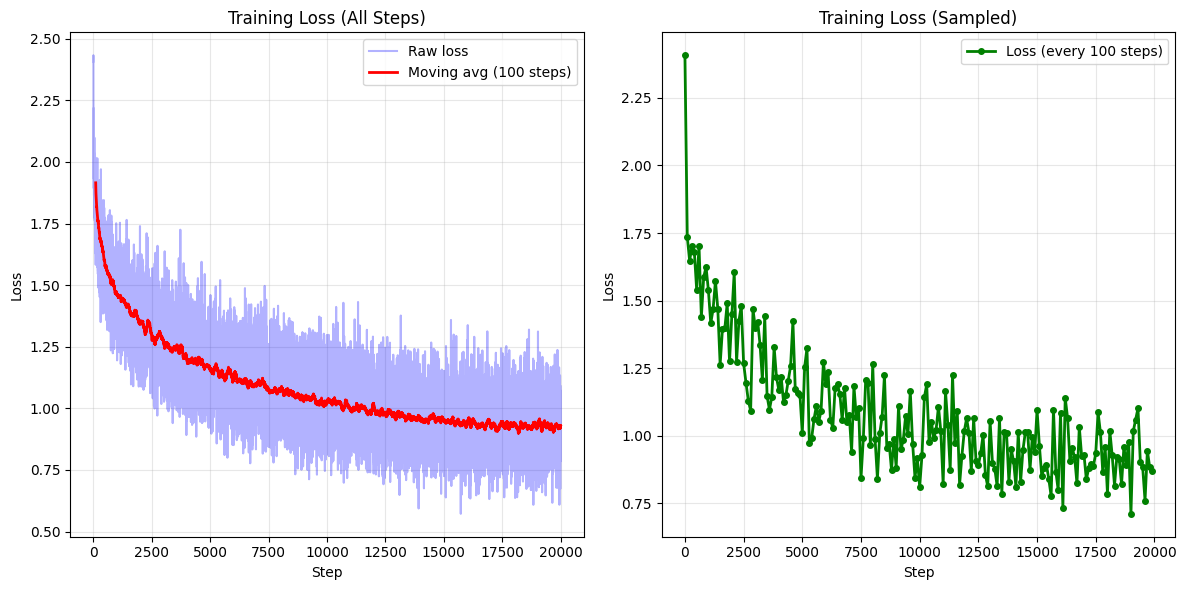


Loss Statistics:
  Initial loss: 2.4073
  Final loss: 1.0894
  Min loss: 0.5721
  Max loss: 2.4333
  Average loss: 1.0871


In [115]:
# Train the model with live loss plotting
# The plot will update in real-time as training progresses
losses, steps = train(model, criterion, optimizer, scheduler, train_loader, num_epochs)

# Optional: Create a final static plot if needed
plot_loss(losses, steps)

In [116]:
evaluate(model, test_loader)

# print optimizer current lr
print(f"Current learning rate: {optimizer.param_groups[0]['lr']}")

losses[0:10]

Accuracy of the network on the 10000 test images: 68.89 %
Current learning rate: 0.0


[2.407325029373169,
 2.4332544803619385,
 2.1971511840820312,
 2.0926828384399414,
 2.2763681411743164,
 2.230783224105835,
 1.9573613405227661,
 2.0666699409484863,
 2.2189769744873047,
 1.9329352378845215]